#  1-ой тест 
### количество данных = 200 
### Эпохи = 20

### ГИПЕРПАРАМЕТРЫ

In [1]:
# Гиперпараметры
SIZE = (256, 256)  # Размер изображений
BATCH_SIZE = 25    # размер батча
MAX_EPOCHS = 20    # количество эпох обучения
STEP_SIZE = 5     # Количество Эпох, через которое меняется шаг обучения
PATIENCE = 20     # Количество Эпох через которое происходит останов обучения, если нет улучшения обучения 
LEN_NEW = 10000     # Длина тренировочного датасета
GAMMA=0.2         # Насколько умножается длина шага обучения 
LEN_DATA = 11000    # Длина всего датасета
RATIO_TEST = 0.05  # Часть для тестового набора
RATIO_TRAIN = 0.8 # Часть для тренировочного набора

## Установка Catalist

In [2]:
%%capture
!pip install catalyst

## Импорты

In [3]:
import os
import numpy as np
import warnings
from IPython.display import clear_output
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
from catalyst.utils import set_global_seed
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import seaborn as sns
from typing import cast
import pandas as pd
from torch.optim import lr_scheduler
from torch import Tensor
import torch.nn as nn
from tqdm.autonotebook import tqdm, trange
from tqdm import tqdm_notebook
import torch.nn.functional as F
from torchvision import models
import copy
import torch.optim as optim
import time
from torchsummary import summary  # для вывода информации о модели
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from matplotlib import rcParams
from skimage import img_as_ubyte
import random

from torch.utils.data.sampler import SubsetRandomSampler  

from PIL import Image
import imageio

sns.set_style('darkgrid')

warnings.filterwarnings("ignore")
np.random.seed(42)
set_global_seed(42)

rcParams['figure.figsize'] = (14,6)

C:\Users\drug1\AppData\Local\Temp\ipykernel_5296\1419334622.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [4]:
# устанавливаем device если gpu или cpu


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("работаем на устройстве: ", device)
print('Версия torch:           ', torch.__version__)
print("версия  cuDNN:          ", torch.backends.cudnn.version())

# ПРОВЕРКА GPU
!nvidia-smi

работаем на устройстве:  cuda
Версия torch:            2.0.1+cu118
версия  cuDNN:           8700
Sun Oct 22 15:14:23 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.42                 Driver Version: 537.42       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   57C    P8              21W / 170W |    324MiB / 12288MiB |      0%      Default |
|                                         |                  

## Дополнительные функции для исследования

In [5]:
# Функция вывода графиков потерь
def display_chart_loss(report): 
    model_list = report['модель'].unique().tolist()  # Получаем список  моделей
    for model_name in model_list:
        data1 = report.loc[report['модель'] == model_name][['Функция потерь', 'Train IOU', 'Val IOU']]
        loss_list = data1['Функция потерь'].unique().tolist()  # Получаем список функций потерь
        
        

        
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        for i, loss in enumerate(loss_list):
            data = report.loc[(report['Функция потерь'] == loss) & (report['модель'] == model_name)][['модель', 'Функция потерь', 'Train loss', 'Val loss']]
            
            Y1 = data['Train loss']  # Первая линия данных 
            Y2 = data['Val loss']    # Вторая линия данных 
            x = np.linspace(1, len(Y1), len(Y1))
            
            # Определяем позицию графика в сетке (i-й график)
            row = i // 2  # Ряд, в котором будет размещен график (0 или 1)
            col = i % 2   # Столбец, в котором будет размещен график (0 или 1)


            # Построение первой линии
            axes[row, col].plot(x, Y1, label='Train loss', color='blue', linestyle='-')

            # Построение второй линии
            axes[row, col].plot(x, Y2, label='Val loss', color='red', linestyle='-')

            axes[row, col].set_xlabel('Эпохи')
            axes[row, col].set_ylabel('Loss')
            axes[row, col].set_xticks(x[::2], x[::2].astype(int))

            # Устанавливаем заголовок графика
            axes[row, col].set_title(f'модель {model_name}, График для функции потерь: {loss}')         
            # Отображаем легенду только на первом графике в каждом ряду
            if col == 0 and row == 0:
                axes[row, col].legend()


        # Регулируем расстояние между графиками, чтобы они не перекрывались
        plt.tight_layout()       
        # Отображаем график
        plt.show()

        
# Функция вывода графиков IoU
def display_chart_iou(report): 
    model_list = report['модель'].unique().tolist()  # Получаем список  моделей
    for model_name in model_list:
        data1 = report.loc[report['модель'] == model_name][['Функция потерь', 'Train IOU', 'Val IOU']]
        
        loss_list = data1['Функция потерь'].unique().tolist()  # Получаем список функций потерь

        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        for i, loss in enumerate(loss_list):
            data = report.loc[(report['Функция потерь'] == loss) & (report['модель'] == model_name)][['модель', 'Функция потерь', 'Train IOU', 'Val IOU']]
            
            Y1 = data['Train IOU']  # Первая линия данных (Train IOU)
            Y2 = data['Val IOU']    # Вторая линия данных (Val IOU)
            x = np.linspace(1, len(Y1), len(Y1))

            # Определяем позицию графика в сетке (i-й график)
            row = i // 2  # Ряд, в котором будет размещен график (0 или 1)
            col = i % 2   # Столбец, в котором будет размещен график (0 или 1)
            
            
            # Построение первой линии
            axes[row, col].plot(x, Y1, label='Train IOU', color='blue', linestyle='-')
            
            # Построение второй линии
            axes[row, col].plot(x, Y2, label='Val IOU', color='red', linestyle='-')
            
            axes[row, col].set_xlabel('Эпохи')
            axes[row, col].set_ylabel('IOU')
            axes[row, col].set_xticks(x[::2], x[::2].astype(int))

            # Устанавливаем заголовок графика
            axes[row, col].set_title(f'Модель: {model_name}, функция потерь: {loss}')         
            # Отображаем легенду только на первом графике в каждом ряду
            if col == 0 and row == 0:
                axes[row, col].legend()
        # Регулируем расстояние между графиками, чтобы они не перекрывались
        plt.tight_layout()       
        # Отображаем график
        plt.show()


In [6]:
def make_report(history):
    """  
    Дополнительная функция для подготовки отчета
    
    """
    experiment, name_Net, loss_name, avg_loss, avg_loss_val, avg_IoU, avg_IoU_val = zip(*history)
    return (pd.DataFrame({ 
                        'номер': experiment,
                        'модель': name_Net,
                        'Функция потерь' : loss_name ,
                        'Train loss' : np.array(avg_loss).astype(float),
                        'Val loss' : np.array(avg_loss_val),
                        'Train IOU': avg_IoU,
                        'Val IOU': avg_IoU_val})

            )

In [7]:
# форматирование времени
def time_format(time_in_seconds):
    # Рассчитываем часы, минуты и секунды
    hours = int(time_in_seconds // 3600)
    minutes = int((time_in_seconds % 3600) // 60)
    seconds = int(time_in_seconds % 60)
    milliseconds = int((time_in_seconds % 60 - seconds) * 1000)
    
    # Вывод результата
    return (f"{hours}:{minutes}:{seconds}:{milliseconds} мс")

In [8]:
# Просмотр модели и параметров
def view_model(model, params=False):
    if params:
        for name, param in model.named_parameters():
            print(f"Parameter name: {name}, dtype: {param.dtype}")
    print(summary(model,(3, 256, 256)))   
    print(model) 

In [9]:
# функция групировки данных в таблице
def sorted_group(report):
    grouped = report.groupby(['модель', 'Функция потерь'])

    # Функция для выбора строки с максимальным Val_IOU
    def get_best_iou(group):

        best_loss_idx = (group['Val IOU']).idxmax()
        return group.loc[best_loss_idx]

    # Применение функции к каждой группе и объединение результатов
    best_iou_rows = grouped.apply(get_best_iou)
    return best_iou_rows.sort_values(by='Val IOU', ascending=False) 

In [10]:
# подсветка в столбцах
def highlight_table(report):
    sorted_report = sorted_group(report)

    def highlight_max(s):
        is_max = s == s.max()
        return ['background-color: green' if v else '' for v in is_max]

    def highlight_min(s):
        is_min = s == s.min()
        return ['background-color: blue' if v else '' for v in is_min]

    # Отформатируйте DataFrame, подсветив максимальные и минимальные значения
    columns_to_highlight_max = ['Train IOU', 'Val IOU']
    columns_to_highlight_min = ['Train loss', 'Val loss']

    styled_report = sorted_report.style
    for col in columns_to_highlight_max:
        styled_report = styled_report.apply(highlight_max, subset=[col], axis=0)
    
    for col in columns_to_highlight_min:
        styled_report = styled_report.apply(highlight_min, subset=[col], axis=0)

    return styled_report



In [11]:
# функция вывода времени в таблице
def time_table(train_time):
    time_t = pd.DataFrame(train_time, columns=['Model', 'Loss Function', 'время', 'time']).sort_values(by='time')
    return time_t

## Загрузка данных

Датасет  Carvana (сегментация автомобилей)

In [12]:
# текущее  расположение
path_dir = os.getcwd()
print(path_dir)
DATA_DIR = os.path.abspath(path_dir + '\\dataset_2\\') 
print(DATA_DIR)

C:\Users\drug1\Anaconda\Pytorch_1\Tests\segmentation_models
C:\Users\drug1\Anaconda\Pytorch_1\Tests\segmentation_models\dataset_2


In [13]:
x_train_dir = os.path.abspath(DATA_DIR + '\\image\\')
y_train_dir = os.path.abspath(DATA_DIR + '\\mask\\')
print(x_train_dir)

C:\Users\drug1\Anaconda\Pytorch_1\Tests\segmentation_models\dataset_2\image


In [14]:
print(device)

cuda


In [15]:
# Пути к сохранённым моделям
pretrained_model_SegNet = 'model_SegNet_pretrained_2.pth'

model_SegNet1 = 'model_SegNet_2.pth'


pretrained_model_Unet1 = 'model_Unet_pretrained_2.pth'
pretrained_model_Unet2 = 'model_Unet2_pretrained_2.pth'

model_Unet1 = 'model_Unet1_2.pth'
model_Unet2 = 'model_Unet2_2.pth'

## Подготовка датасета

In [16]:
class CustomDataset(Dataset):
    def __init__(self, x_dir, y_dir, transform=0, target_size=SIZE, data_full=False, max_samples=None):
        self.x_dir = x_dir
        self.y_dir = y_dir
        self.target_size = target_size
        self.x_files = os.listdir(x_dir)
        self.y_files = os.listdir(y_dir)
        self.data_full = data_full
        
        self.transform = transform 

        if max_samples is not None:
            if max_samples > len(self.x_files):
                max_samples = len(self.x_files)
            self.x_files = self.x_files[:max_samples+1]
            self.y_files = self.y_files[:max_samples+1]
        
        if self.data_full:
            # Загружаем все данные в оперативную память
            self.x_images = [resize(imread(os.path.join(x_dir, fname)), self.target_size, mode='constant', anti_aliasing=True) for fname in self.x_files]
            self.y_images = [(resize(imread(os.path.join(y_dir, fname)), self.target_size, mode='constant', anti_aliasing=True) > 0.5).astype(float) for fname in self.y_files]       
        
    def __len__(self):
        return len(self.x_files)

    def __getitem__(self, idx):
        
        # Загружаем все данные в оперативную память
        if self.data_full:
        # ######################################################
            x_image = self.x_images[idx]
            y_image = self.y_images[idx]       
        # ##################################################
        else:     
            # Загружаем  данные в оперативную память частями
            # ####################################################################
            x_file = os.path.join(self.x_dir, self.x_files[idx])
            y_file = os.path.join(self.y_dir, self.y_files[idx])

            x_image = imread(x_file)  #  Загружаем изображение
            y_image = imread(y_file)

            x_image = resize(x_image, self.target_size, mode='constant', anti_aliasing=True)  #  преобразуем размер
            y_image = resize(y_image, self.target_size, mode='constant', anti_aliasing=True)  #  преобразуем размер 
            # Применяем пороговую обработку
            y_image = (y_image > 0.5)        
            # #####################################################################  
 
        # Преобразование в тензоры
        x_image = torch.from_numpy(x_image).float().permute(2, 0, 1)
        y_image = torch.from_numpy(y_image).float().unsqueeze(0)
                       
        if self.transform > 0:
            num_transform =random.randint(0, self.transform + 5)
            if num_transform == 1:   # Поворот
                angle = random.choice([1, 2, 3])
                x_image = torch.rot90(x_image, k=angle, dims=(1, 2))
                y_image = torch.rot90(y_image, k=angle, dims=(1, 2)) 
            elif num_transform == 2:  # Отражение по X
                x_image = torch.flip(x_image, dims=(2,))
                y_image = torch.flip(y_image, dims=(2,)) 
            elif num_transform == 3:  # Отражение по Y
                x_image = torch.flip(x_image, dims=(1,))
                y_image = torch.flip(y_image, dims=(1,))                
            elif num_transform == 4:  # отражение и поворот
                x_image = torch.flip(x_image, dims=(1,))
                y_image = torch.flip(y_image, dims=(1,)) 
                angle = random.choice([1, 3])
                x_image = torch.rot90(x_image, k=angle, dims=(1, 2))
                y_image = torch.rot90(y_image, k=angle, dims=(1, 2)) 
            elif num_transform == 5:
                x_image = torch.flip(x_image, dims=(1,))
                y_image = torch.flip(y_image, dims=(1,)) 
                x_image = torch.rot90(x_image, k=1, dims=(1, 2))
                y_image = torch.rot90(y_image, k=1, dims=(1, 2))
              
        return x_image, y_image


## DataLoader

In [17]:
# получаем тестовый даталоадер
def random_shuffle_data(custom_dataset, batch_size=BATCH_SIZE, len_data=LEN_DATA, ratio_test=RATIO_TEST):  
    # ratio_test - процент тестовых данных
    
    total_samples = len(custom_dataset)
    # Количество элементов из которых выбираем датасет
    if len_data > total_samples:
        len_data = total_samples
        
    test_size = int(ratio_test * len_data)
        
    # Рандомно деление датасета на тренировочный, валидационный и тестовый набор
    mas_ix = np.random.choice(total_samples, len_data, False)  # массив индексов перемешанных рандомно
    
    test_ix, no_test_ix = np.split(mas_ix, [test_size])
    test_sampler = SubsetRandomSampler(test_ix)
    data_ts = DataLoader(custom_dataset, batch_size=BATCH_SIZE, sampler=test_sampler)
    return test_ix, no_test_ix, data_ts

In [18]:
#  создание списков индексов для даталоадеров тренировачного и валидационного
def load_data(no_test_ix=[], len_new=0, batch_size=BATCH_SIZE, ratio_train=RATIO_TRAIN):
    # no_test_ix -  массив  индексов для датасета
    # len_new - длина массива индексов для датасета
    
    len_data_ix = len(no_test_ix) # количество данных 
    if len_new > len_data_ix:
        len_new = len_data_ix
    if len_new < len_data_ix:
        len_data_ix = len_new    
    # перемешиваем  индексы
    random.shuffle(no_test_ix)   
    # вычисляем размеры датасета
    train_size = int(ratio_train * len_data_ix)   
    # Рандомно деление датасета на тренировочный, валидационный и тестовый набор
    train_ix = no_test_ix[:train_size]
    val_ix = no_test_ix[train_size:len_new+1] 
        
    return train_ix, val_ix

### Пример работы  Dataloader

In [19]:
# Создаем экземпляр CustomDataset
custom_dataset = CustomDataset(x_train_dir, y_train_dir, transform=1, data_full=False, max_samples=LEN_DATA)

len_new=21

len_data=len(custom_dataset)
print("Датасет всего: ", len_data)

# создание тестового даталоадера и списка индексов оставшихся, вводим необходимую длину датасета
# создаём один раз перед началом обучения
test_ix, no_test_ix, data_ts = random_shuffle_data(custom_dataset, len_data=len_data, ratio_test=0.1)
print("длина тестового датасета: ", len(test_ix))
print("Оставшиеся данные: ", len(no_test_ix), "количество батчей для теста: ", len(data_ts))

#  создание списков индексов тренировачного и валидационного датасета, вводим необходимую длину нового датасета
train_ix, val_ix = load_data(no_test_ix=no_test_ix, len_new=len_new)
print("Данных для тренировки: ", len(train_ix), "данных для валидации: ", len(val_ix))

# перемешиваем индексы
train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix) 

# Создаём загрузчики
data_tr = DataLoader(custom_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
data_val = DataLoader(custom_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

print("длина датасета: ", len_new)
print("количество батчей для тренировки и валидации:", len(data_tr), len(data_val))

Датасет всего:  11001
длина тестового датасета:  1100
Оставшиеся данные:  9901 количество батчей для теста:  44
Данных для тренировки:  16 данных для валидации:  6
длина датасета:  21
количество батчей для тренировки и валидации: 1 1


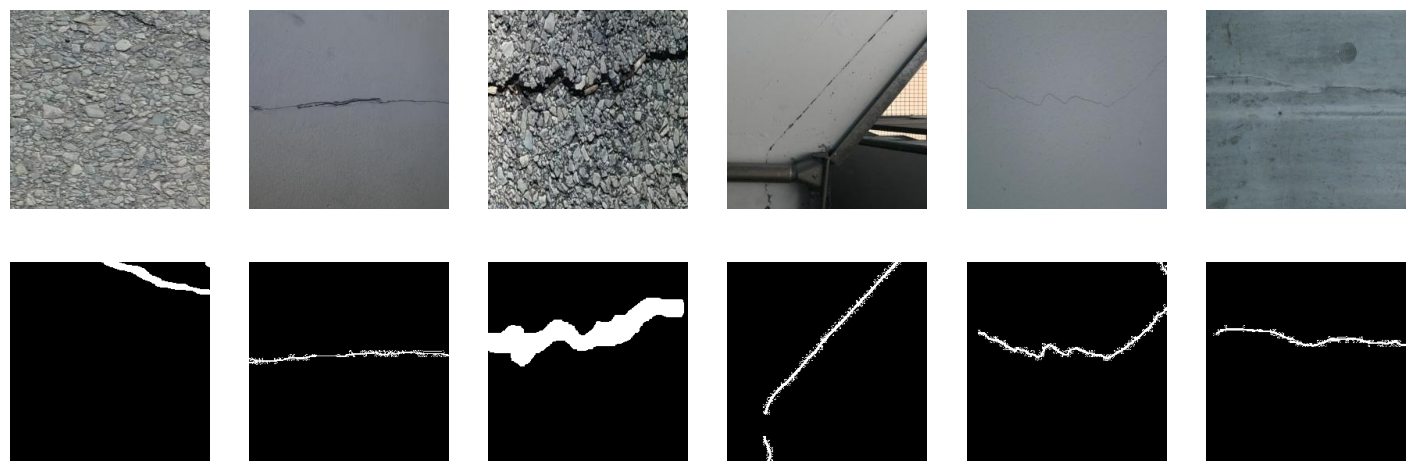

In [20]:
# Вывод изображений
for x, y in data_val:
    # print(y[0].max())
    plt.figure(figsize=(18, 6))
    for i in range(6):
        plt.subplot(2, 6, i+1)
        plt.axis("off")
        
        # Преобразуем тензоры PyTorch в массивы NumPy перед отображением
        
        p = x[i].permute(1, 2, 0) # меняем размерности
        plt.imshow(p.numpy())
        plt.subplot(2, 6, i+7)
        plt.axis("off")
        
        # Преобразуем тензоры PyTorch в массивы NumPy перед отображением
        
        plt.imshow(y[i].squeeze().numpy(), cmap='gray')  # Убираем размерность
        
    plt.show()
    break
    
    
with torch.no_grad():
    torch.cuda.empty_cache()  #очистить ресурсы  GPU

## Функции загрузки модели

In [21]:
# загрузка модели
def load_models(model_filename, name_Net="SegNet"):
    # Создание модели
    if name_Net == "SegNet":
        model = SegNet().to(device)
    elif name_Net == "UNet":
        model = UNet().to(device)
    elif name_Net == "UNet2":
        model = UNet2().to(device)
    else:
        model = SegNet().to(device)
        
    if model_filename =="":
        if name_Net == "SegNet":
            model_filename = model_SegNet1        
        elif name_Net == "UNet":
            model_filename =  model_Unet1      
        elif name_Net == "UNet2":
            model_filename =  model_Unet2     
        else:
            model_filename = model_filename
        
    
    
    # Загрузка  модели если ранее сохранена была
    if os.path.isfile(model_filename):
        # Попытка загрузить модель
        try:
            model.load_state_dict(torch.load(model_filename))
            print("Модель успешно загружена и готова к использованию.")
            return model
        except Exception as e:
            print(f"Произошла ошибка при загрузке модели: {e}")
    else:
        print("Файл модели не существует.")
        return model
    

## Метрика

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$  

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины,  
тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.

In [22]:
# Функция метрики
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = outputs.squeeze(1).byte() 
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-9
    intersection = (outputs & labels).float().sum((1, 2)) 
    union = (outputs | labels).float().sum((1, 2))    
    
    iou = (intersection + SMOOTH) / (union + SMOOTH) 
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  
    
    return thresholded.mean()

## Функции потерь




In [23]:
def bce_loss_torch(y_real, y_pred):
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    y_pred = y_pred.type(torch.float32)
    y_real = y_real.type(torch.float32)

    loss = F.relu(y_pred) - y_real * y_pred + torch.log(1. + torch.exp(-abs(y_pred)))
    return torch.mean(loss)


def dice_loss(y_real, y_pred):

    SMOOTH = 1e-8

    y_pred = F.sigmoid(y_pred)

    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)   

    num = 2. * torch.sum(y_pred * y_real)
    den = torch.sum(y_pred**2) + torch.sum(y_real**2)
    res = (num) / (den + SMOOTH)

    return 1. - res



def focal_loss(y_real, y_pred):

    GAMMA1 = 2
    ALPHA = .8
    y_pred = y_pred.type(torch.float32)
    y_real = y_real.type(torch.float32)

    BCE = bce_loss_torch(y_real, y_pred)
    pt = torch.exp(-BCE)
    focal_loss = ALPHA * (1. - pt)**GAMMA1 * BCE

    return focal_loss


# https://arxiv.org/pdf/1705.08790.pdf
def grad_lovasz(sorted_errors):

    err_cumm = sorted_errors.float().cumsum(0)
    opp_err_cumm = (1 - sorted_errors).float().cumsum(0)
    p = len(sorted_errors)
    err = sorted_errors.sum()
    intersection = err - err_cumm
    union = err + opp_err_cumm
    grad = 1 - intersection / union
    if p > 1:
        grad[1:p] = grad[1:p] - grad[0:p-1]
    return grad


# https://arxiv.org/pdf/1512.07797.pdf. 
def lovasz_hinge(y_real, y_pred):

    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    sgn = 2 * y_real.float() - 1
    errs = (1 - y_pred * torch.tensor(sgn, requires_grad=True))
    sorted_errors, indices = torch.sort(errs, dim=0, descending=True)
    indices = indices.data
    errs_for_grad = y_real[indices]
    grad = grad_lovasz(errs_for_grad)
    loss = torch.dot(F.relu(sorted_errors), torch.tensor(grad, requires_grad=True))
    return loss



## Функция тренировки

In [24]:
def train(custom_dataset, history, train_time, name_Net, patch_pretrained_model, patch_name_model, loss_mas, metric, epochs, patience=None, len_new=LEN_NEW,
          ratio_train=RATIO_TRAIN, ratio_test=RATIO_TEST, batch_size=BATCH_SIZE):
    # name_Net - название модели
    # patch_name_model - путь для сохранения модели сети
    # opt - оптимизатор
    # loss_mas - Функция потерь
    # metric - Метрика
    # epochs - Количество эпох
    # data_tr, data_val - наборы данных 
    # scheduler - Планировщик (управляет скоростью обучения)
    # patience  - терпимость, через сколько эпох остановить обучение, если нет улучшения
   
  
    
    """Создаём тестовый загрузчик"""
    test_ix, no_test_ix, data_ts = random_shuffle_data(custom_dataset, batch_size=batch_size, len_data=len(custom_dataset), ratio_test=ratio_test) # Создание тестового даталоадера
    print("длина тестового датасета: ", len(test_ix))
    print("Данных для тренировки: ", len(no_test_ix), "количество батчей для теста: ", len(data_ts))
    
    x_ts, y_ts = next(iter(data_ts))  # тестовый набор для сравнения процесса обучения (вывод изображений)
    
    """обучение по разным loss"""
    for experiment, los in enumerate(loss_mas):
        with torch.no_grad():   # Очищаем память
            torch.cuda.empty_cache()
              
#         #  создание списков индексов тренировачного и валидационного датасета, вводим необходимую длину датасета
#         train_ix, val_ix = load_data(no_test_ix=no_test_ix, len_new=len_new, ratio_train=ratio_train)
     
#         # создаём лоадеры
#         # перемешиваем индексы
#         train_sampler = SubsetRandomSampler(train_ix)
#         val_sampler = SubsetRandomSampler(val_ix) 

#         # Создаём загрузчики
#         data_tr = DataLoader(custom_dataset, batch_size=batch_size, sampler=train_sampler)
#         data_val = DataLoader(custom_dataset, batch_size=batch_size, sampler=val_sampler)
#         print("длина датасета: ", len_new)
#         print("количество батчей для тренировки и валидации:", len(data_tr), len(data_val))
       
        
        
        """Обучение"""
        best_val_loss =  np.inf
        patience_count = 0
    
        # Создаём модель
        model = load_models(patch_pretrained_model, name_Net)    
        # opt = opt(model.parameters(), lr=1e-4)  # ОПТИМИЗАТОР
        opt = optim.Adam(model.parameters(), lr=1e-4)  # ОПТИМИЗАТОР
        scheduler = lr_scheduler.StepLR(opt, step_size=STEP_SIZE, gamma=GAMMA) # Планировщик (управляет скоростью обучения)
    
    
        start = time.time()  # НАЧАЛО ОБУЧЕНИЯ
        # Цикл обучения
        for epoch in range(epochs):  # Проход по эпохам
            # set_global_seed(42 + epoch)

            if epoch == 0:
                len_new = 10000
            elif epoch < 4:
                len_new = 3000 
            elif epoch == 5:
                len_new = 10000     
            elif epoch < 9:
                len_new = 6000 
            elif epoch == 10:
                len_new = 10000 
            elif epoch < 14:
                len_new = 9000
            elif epoch == 14:
                len_new = 10000 
            elif epoch < 19:
                len_new = 11000 
            elif epoch == 19:
                len_new = 10000     
            else:
                len_new = 11000
            
            print("len_data", len_new)
            
            #  создание списков индексов тренировачного и валидационного датасета, вводим необходимую длину датасета
            train_ix, val_ix = load_data(no_test_ix=no_test_ix, len_new=len_new, ratio_train=ratio_train)

            # создаём лоадеры
            # перемешиваем индексы
            train_sampler = SubsetRandomSampler(train_ix)
            val_sampler = SubsetRandomSampler(val_ix) 

            # Создаём загрузчики
            data_tr = DataLoader(custom_dataset, batch_size=batch_size, sampler=train_sampler)
            data_val = DataLoader(custom_dataset, batch_size=batch_size, sampler=val_sampler)
            # print("длина датасета: ", len_new)
            # print("количество батчей для тренировки и валидации:", len(data_tr), len(data_val))
            
            
            model.train()   # Переводим модель в состояние тренировки
            print(f'ЭПОХА {epoch+1}/{epochs}')  # Выводим номер текущей  эпохи

            # Создаём прогресбар тренировки
            progress_bar_train = tqdm(data_tr, total=len(data_tr), desc='Тренировка', leave=True)

            # Запускаем обучение
            avg_loss = 0  # Инициализация переменной avg_loss перед использованием
            avg_IoU = 0
            for x_batch, y_batch in progress_bar_train:  #  Проход по батчам - ТРЕНИРОВКА
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)

                    opt.zero_grad()
                    y_pred = model(x_batch)  # Предсказываем 

                    loss1 = los(y_batch, y_pred)

                    loss1.backward()  # Вычисляем градиенты функции потерь (loss) для оптимизации
                    opt.step()  # делаем шаг оптимизации

                    iou = metric(torch.round(F.sigmoid(y_pred)), y_batch) #  функция расчета IоU 

                    avg_loss += loss1  # Добавление текущего лосса к avg_loss
                    avg_IoU += iou
                    progress_bar_train.set_postfix(Loss=loss1.detach().cpu().item(), IoU=iou.detach().cpu().mean().item())  # Изменяем прогресбар    
                    
                    
                    
            avg_loss /= len(data_tr)  # Усреднение лосса по всем пакетам данных (для вывода статистики)
            avg_IoU /= len(data_tr)   # Усреднение IoU по всем пакетам данных

            # tqdm-объект для отслеживания прогресса валидации
            progress_bar_val = tqdm(data_val, total=len(data_val), desc='Валидация', leave=True)

            with torch.no_grad():
                model.eval() 
                avg_loss_val = 0  # Инициализация переменной avg_loss перед использованием
                avg_IoU_val = 0
                for x_batch, y_batch in progress_bar_val:  #  Проход по батчам - ТРЕНИРОВКА
                        x_batch = x_batch.to(device)
                        y_batch = y_batch.to(device) 
                        y_pred = model(x_batch)  # Предсказываем 

                        loss1 =  los(y_batch, y_pred)  # функция потерь
                        iou1 = metric(torch.round(F.sigmoid(y_pred)), y_batch) #  функция расчета IоU
                        
                      
                        avg_loss_val += loss1  # Добавление текущего лосса к avg_loss
                        
                        avg_IoU_val += iou1

                        progress_bar_val.set_postfix(loss=loss1.detach().cpu().item(), IoU=iou1.detach().cpu().mean().item())  # Изменяем прогресбар

                avg_loss_val /= len(data_val)  # Усреднение лосса по всем пакетам данных  (Для вывода статистики)
                avg_IoU_val = avg_IoU_val/len(data_val)   # Усреднение IoU по всем пакетам данных

            # шаг шедулера, если указан
            if scheduler is not None:
                scheduler.step()

            # проверка лосса
            if(best_val_loss > avg_loss_val.item()):
                patience_count = 0
                best_val_loss = avg_loss_val.item()
                torch.save(model.state_dict(), patch_name_model) # Сохранение лучшей модели
            if patience is not None:
                if(patience_count > patience):
                    break
                patience_count += 1

            
            
            # Для вывода графика примеров предсказанных масок
            with torch.no_grad():
                inputs = x_ts.to(device)
                model.eval()        
                y_hat = torch.round(F.sigmoid(model(inputs)))
                clear_output(wait=True)
                n = 5
                if len(x_ts) < 5:
                    n = len(x_ts)
                for k in range(n):
                    plt.subplot(3, n, k+1)
                    plt.imshow(x_ts[k].permute(1, 2, 0).numpy())
                    plt.title('Изображение')
                    plt.axis('off')

                    plt.subplot(3, n, k+n+1)
                    plt.imshow(y_ts[k].squeeze(0).numpy(), cmap='gray')
                    plt.title('Реальная маска')
                    plt.axis('off')

                    plt.subplot(3, n, k+2*n+1)
                    plt.imshow(y_hat[k, 0].cpu().numpy(), cmap='gray')
                    plt.title('Предсказанная маска')
                    plt.axis('off')

                    
                avg_loss_cpu = avg_loss.detach().cpu().numpy()
                avg_loss_val_cpu = avg_loss_val.detach().cpu().numpy()
                avg_iou_cpu = avg_IoU.detach().cpu().numpy()
                avg_iou_val_cpu = avg_IoU_val.detach().cpu().numpy()   
                
                history.append((experiment + 1, name_Net, los.__name__, avg_loss_cpu, avg_loss_val_cpu, avg_iou_cpu, avg_iou_val_cpu))   
                
                plt.suptitle(f'{name_Net} - {los.__name__} /// Эпоха {epoch+1}/{epochs} /// Train- Loss: {avg_loss_cpu:.4f} / IoU: {avg_iou_cpu.mean().item(): .4f}   /// Val- Loss: {avg_loss_val_cpu:.4f} / IoU: {avg_iou_val_cpu.mean().item(): .4f}')
                plt.show()
        
        end = time.time()  # Конец обучения
        elapsed = end - start  # Время обучения
        train_time.append((name_Net, los.__name__, time_format(elapsed), elapsed)) # сохраняем время обучения для модели
        
    # model = load_models(patch_name_model, name_Net) # загружаем лучшую модель  
    return history

In [25]:
# Функция предсказания
def predict(model, data, activate, num_image=1):
    with torch.no_grad():
        model.eval()
        i=0
        for d in data:
            i += 1
            if i > num_image:
                return
            x_batch = d[0].to(device)
            y_label = d[1].to(device)
            y_pred = torch.round(activate(model(x_batch)))
            y_pred1 = y_pred[0].squeeze(0)   
            # print(y_pred1.shape)
        
            y_label1 = y_label[0].squeeze(0)  
            # print(y_label1.shape)

            x_batch1 = x_batch[0].permute(1, 2, 0)
            # print(x_batch1.shape)
            
            plt.figure(figsize=(15, 5))
            plt.axis("off")

            plt.subplot(1, 3, 1)  # Первая ячейка сетки
            plt.imshow(x_batch1.cpu())
            plt.title('Изображение')
            plt.subplot(1, 3, 2)  # Вторая ячейка сетки        
            plt.imshow(y_label1.cpu(), cmap='gray')
            plt.title('Реальная маска')
            plt.subplot(1, 3, 3)  # Вторая ячейка сетки       
            plt.imshow(y_pred1.cpu(), cmap='gray')
            plt.title('Предсказанная маска')
            plt.show();
        

In [26]:
# функция сравнения результата по метрике
def score_model(model, metric, data):
    with torch.no_grad():
        model.eval() 
        scores = 0
      
        for x_batch, y_label in data:
            x_batch = x_batch.to(device)
            y_label = y_label.to(device)

            y_pred = torch.round(F.sigmoid(model(x_batch)))
            scores += metric(y_pred, y_label).mean().item()

    return scores/len(data)

## МОДЕЛИ

### SegNet
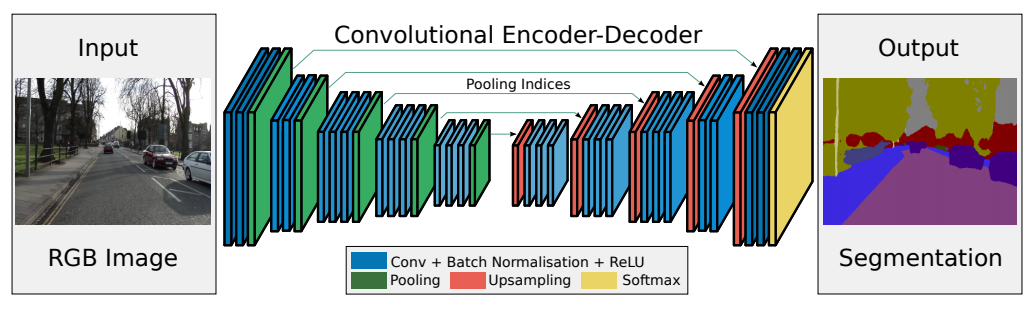


Построим архитектуру нашей сети - будет 5 блоков с 3 входами (включая, bottleneck) на кодирование информации и 5 блоков с 1 выходом на декодирование. На первых двух блоках и двух последних - будет два сверточных слоя с нормализацией, на 3 последних Downsampling и 3 первых Upsampling слоев будет 3 сверточных слоя. Количество фильтров будет возрастать от 64 до 512. Слой MaxPool2d будет возвращать индексы для слоев MaxUnpool2d

In [27]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        kernel = 3
        padding = 1
        pool = 2

        input = 3
        output = 1

        self.enc_conv0 = nn.Sequential(
            
                  nn.Conv2d(input, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(pool, stride=pool, return_indices=True) 
        self.enc_conv1 = nn.Sequential(
            
                  nn.Conv2d(64, 128, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 128, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(128),
                  nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(pool, stride=pool, return_indices=True) 
        self.enc_conv2 = nn.Sequential(
            
                  nn.Conv2d(128, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(pool, stride=pool, return_indices=True) 
        self.enc_conv3 = nn.Sequential(
            
                  nn.Conv2d(256, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(pool, stride=pool, return_indices=True) 

       
        # bottleneck

        self.bottleneck_conv = nn.Sequential(
            


                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU()
        )        
        self.pool4 = nn.MaxPool2d(pool, stride=pool, return_indices=True) 
        # decoding
        self.upsample0 =  nn.MaxUnpool2d(kernel_size=pool, stride=pool) 
        self.dec_conv0 =  nn.Sequential(
            
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU()
        )


        self.upsample1 =  nn.MaxUnpool2d(kernel_size=pool, stride=pool) 
        self.dec_conv1 =  nn.Sequential(
            
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU()
        )
        self.upsample2 =  nn.MaxUnpool2d(kernel_size=pool, stride=pool)
        self.dec_conv2 =  nn.Sequential(
            
                  nn.Conv2d(256, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 128, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(128),
                  nn.ReLU()
        )
        self.upsample3 =  nn.MaxUnpool2d(kernel_size=pool, stride=pool)
        self.dec_conv3 =  nn.Sequential(
            
                  nn.Conv2d(128, 128, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU()
        )
        self.upsample4 =  nn.MaxUnpool2d(kernel_size=pool, stride=pool)
        self.dec_conv4 = nn.Sequential(
            
                  nn.Conv2d(64, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, output, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(output),

        )

    def forward(self, x):
        # encoder
        x = self.enc_conv0(x)
        x, ind0 = self.pool0(x)
        size0 = x.size()
        
        x = self.enc_conv1(x)
        x, ind1 = self.pool1(x)
        size1 = x.size()

        x = self.enc_conv2(x)
        x, ind2 = self.pool2(x)
        size2 = x.size()

        x = self.enc_conv3(x)
        x, ind3 = self.pool3(x)
        size3 = x.size()
        
        # bottleneck
        x = self.bottleneck_conv(x)
        x, ind4 = self.pool4(x)

        # decoder
        x = self.upsample0(x, ind4, output_size=size3)
        x = self.dec_conv0(x)

        x = self.upsample1(x, ind3, output_size=size2)
        x = self.dec_conv1(x)

        x = self.upsample2(x, ind2, output_size=size1)
        x = self.dec_conv2(x)

        x = self.upsample3(x, ind1, output_size=size0)
        x = self.dec_conv3(x)

        x = self.upsample4(x, ind0)
        x = self.dec_conv4(x)
        return x

### U-Net

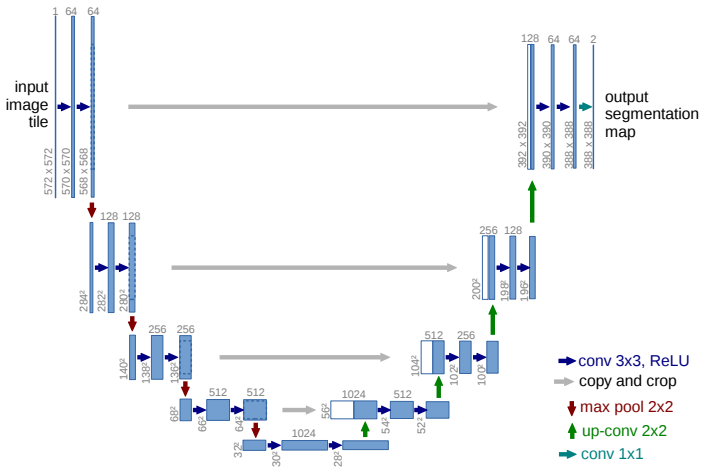

#### U-Net базовая UpsamplingNearest2d

In [28]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        kernel = 3
        padding = 1
        pool = 2
        input = 3
        output = 1

        # encoder (downsampling)

        self.down_1 =  nn.Sequential(
            
                  nn.Conv2d(input, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU()
        )

        self.pool1 = nn.MaxPool2d(pool, stride=pool)

        self.down_2 =  nn.Sequential(
            
                  nn.Conv2d(64, 128, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 128, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(128),
                  nn.ReLU()
        )

        self.pool2 = nn.MaxPool2d(pool, stride=pool)

        self.down_3 =  nn.Sequential(
            
                  nn.Conv2d(128, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU()
        )
        
        self.pool3 = nn.MaxPool2d(pool, stride=pool)
        self.down_4 =  nn.Sequential (
            
                  nn.Conv2d(256, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
        )
        self.pool4 = nn.MaxPool2d(pool, stride=pool)
       

        # bottleneck

        self.bottleneck_conv = nn.Sequential(
            


                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),

        )        
        
        # decoder (upsampling)

        self.upsample0 =  nn.UpsamplingNearest2d(scale_factor=2)
        self.dec_conv0 =  nn.Sequential(
            
                      nn.Conv2d(1024, 512, kernel_size=kernel, padding=padding),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(512, 256, kernel_size=kernel, padding=padding),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
        )

        self.upsample1 =  nn.UpsamplingNearest2d(scale_factor=2)
        self.dec_conv1 =  nn.Sequential(
            
                      nn.Conv2d(512, 256, kernel_size=kernel, padding=padding),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(256, 128, kernel_size=kernel, padding=padding),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
        )

        self.upsample2 =  nn.UpsamplingNearest2d(scale_factor=2)
        self.dec_conv2 =  nn.Sequential(
            
                      nn.Conv2d(256, 128, kernel_size=kernel, padding=padding),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.Conv2d(128, 64, kernel_size=kernel, padding=padding),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
        )
 
        self.upsample3 =  nn.UpsamplingNearest2d(scale_factor=2)
        self.dec_conv3 =  nn.Sequential(
            
                  nn.Conv2d(128, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, output, kernel_size=1),
                  nn.BatchNorm2d(output)

        )


                   

    def forward(self, x):
        # encoder (downsampling)
        out_1 = self.down_1(x)
        out_pool_1 = self.pool1(out_1)

        out_2 = self.down_2(out_pool_1)
        out_pool_2 = self.pool2(out_2)

        out_3 = self.down_3(out_pool_2)
        out_pool_3 = self.pool3(out_3)

        out_4 = self.down_4(out_pool_3)
        out_pool_4 = self.pool4(out_4)

        # bottleneck

        bottleneck = self.bottleneck_conv(out_pool_4)

        # decoder (upsampling)
        up_1 = self.upsample0(bottleneck)
        up_out_1 = torch.cat((up_1, out_4), dim=1)
        out_5 = self.dec_conv0(up_out_1)


        up_2 = self.upsample1(out_5)
        up_out_2 = torch.cat((up_2, out_3), dim=1)
        out_6 = self.dec_conv1(up_out_2)

        up_3 = self.upsample2(out_6)
        up_out_3 = torch.cat((up_3, out_2), dim=1)
        out_7 = self.dec_conv2(up_out_3)

        up_4 = self.upsample3(out_7)
        up_out_4 = torch.cat((up_4, out_1), dim=1)
        preds = self.dec_conv3(up_out_4)
        return preds

#### U-Net с ConvTranspose2d

In [29]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.down_1 = self.downsampling_(3, 64)
        self.down_2 = self.downsampling_(64, 128)
        self.down_3 = self.downsampling_(128, 256)
        self.down_4_bottle = self.bottleneck_conv(256, 512)

        self.upsample1 = self.upsampling_(512, 256)
        self.upsample2 = self.upsampling_(256, 128)
        self.upsample3 = self.upsampling_(128, 64)

        self.preds = nn.Sequential(
            nn.ConvTranspose2d(
                64, 1, kernel_size=3, padding=1, stride=2, output_padding=1
            )
        )

    def downsampling_(self, in_chan, out_chan):
        return nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )


    def bottleneck_conv(self, in_chan, out_chan):
        return nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU()

        )       
  

    def upsampling_(self, in_chan, out_chan):
        return nn.ModuleList(
            [
                nn.ConvTranspose2d(in_chan, out_chan, kernel_size=3,
                                   stride=2, padding=1, output_padding=1),
              # обязательно задать на первый модуль output_padding - определяет форму вывода
                nn.BatchNorm2d(2 * out_chan),
                nn.ReLU(),
                nn.ConvTranspose2d(2 * out_chan, out_chan, kernel_size=3,
                                   stride=1, padding=1),
              # обязательно задать stride = 1, вместо 2 - иначе на вход следующему слою придет меньше фильтров
                nn.BatchNorm2d(out_chan),
                nn.ReLU(),
            ]
        )

    def forward(self, x):
        out_1 = self.down_1(x)
        out_2 = self.down_2(out_1)
        out_3 = self.down_3(out_2)
        out_4 = self.down_4_bottle(out_3)


        up_out_1 = self.upsample1[0](out_4)
        up_out_1 = torch.cat([out_3, up_out_1], dim=1)
        for out_ in self.upsample1[1:]:
            up_out_1 = out_(up_out_1)

        up_out_2 = self.upsample2[0](up_out_1)
        up_out_2 = torch.cat([out_2, up_out_2], dim=1)
        for out_ in self.upsample2[1:]:
            up_out_2 = out_(up_out_2)

        up_out_3 = self.upsample3[0](up_out_2)
        up_out_3 = torch.cat([out_1, up_out_3], dim=1)
        for out_ in self.upsample3[1:]:
            up_out_3 = out_(up_out_3)
     

        preds = self.preds(up_out_3)
        return preds

## ОБУЧЕНИЕ

In [30]:
with torch.no_grad():
    torch.cuda.empty_cache()

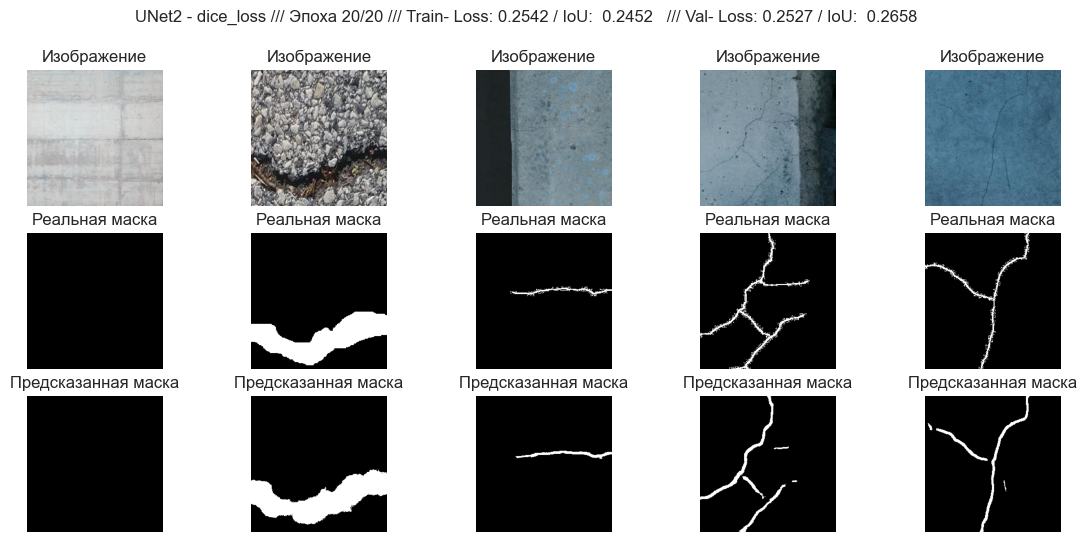

In [31]:
"""Параметры модели"""
ratio_test = 0.09  # процент тестового датасета
ratio_train = 0.8  # процент тренировочного датасета от оставшегося датасета после теста
patience = PATIENCE  # терпимость, через сколько эпох остановить обучение, если нет улучшения
len_new = LEN_NEW  # длина тренировочного датасета (которую хотим использовать)
epochs = MAX_EPOCHS # эпохи
batch_size=BATCH_SIZE
step_size=STEP_SIZE # количество шагов через которое изменяем скорость

# opt = optim.Adam(model.parameters(), lr=1e-4)  # ОПТИМИЗАТОР
# scheduler = lr_scheduler.StepLR(opt, step_size=step_size, gamma=0.1) # Планировщик (управляет скоростью обучения)
# opt = optim.Adam(model.parameters(), lr=1e-4)  # ОПТИМИЗАТОР
models = ["SegNet", "UNet", "UNet2"]# модель для обучения
# pretrained_model = pretrained_model_SegNet  # натренированная модель для загрузки если есть
pretrained_models = [pretrained_model_SegNet, pretrained_model_Unet1, pretrained_model_Unet2]
save_models = [model_SegNet1, model_Unet1, model_Unet2]  #  куда сохраняем модель 
loss = [bce_loss_torch, dice_loss, focal_loss, lovasz_hinge] #  функция потерь
#loss = [bce_loss_torch, dice_loss] #  функция потерь
metric = iou_pytorch  # Метрика
history = []
train_time = []

loss = [dice_loss] #  функция потерь
# models = ["UNet2"]# модель для обучения

# Создаем экземпляр CustomDataset
custom_dataset = CustomDataset(x_train_dir, y_train_dir, transform=1, data_full=True, max_samples=LEN_DATA)


"""Тренировка"""
for model in models:
    if model == "SegNet":
        pretrained_model = pretrained_models[0]
        save_model = save_models[0]
    elif model == "UNet":   
        pretrained_model = pretrained_models[1]
        save_model = save_models[1]
    elif model == "UNet2":   
        pretrained_model = pretrained_models[2]
        save_model = save_models[2]  
    else:
        pretrained_model = pretrained_models[0]
        save_model = save_models[0]
    
    
    history = train(
                custom_dataset,
                history,
                train_time,
                model, 
                pretrained_model, 
                save_model,
                loss, 
                metric,
                epochs,  
                patience=patience,
                len_new=len_new,
                ratio_train=ratio_train, 
                ratio_test=ratio_test
                  )





## Сводная информация

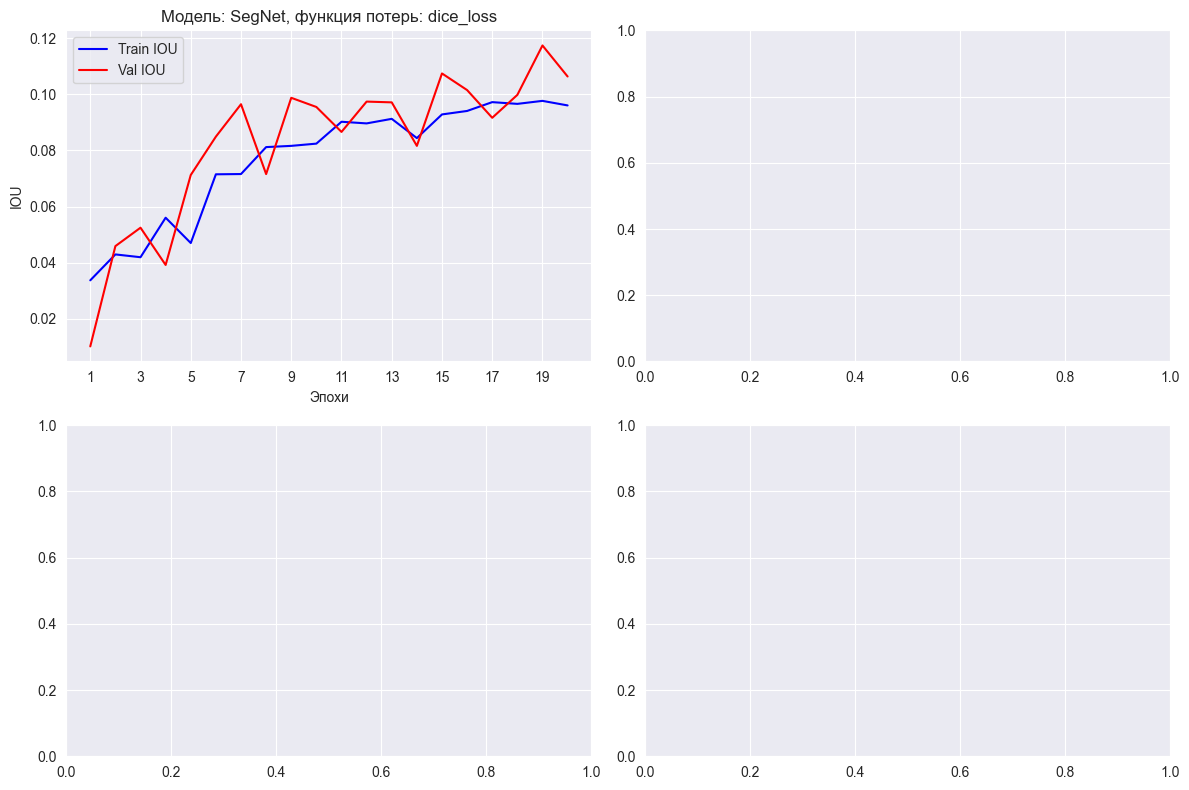

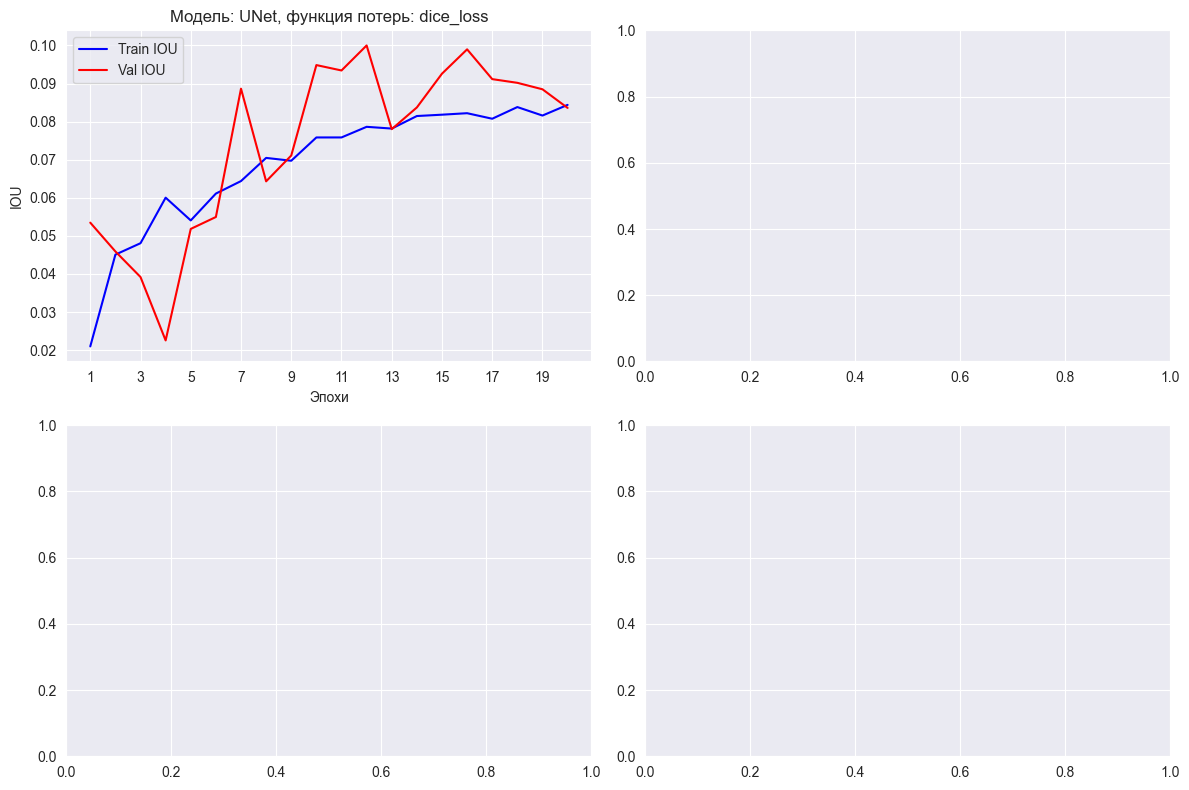

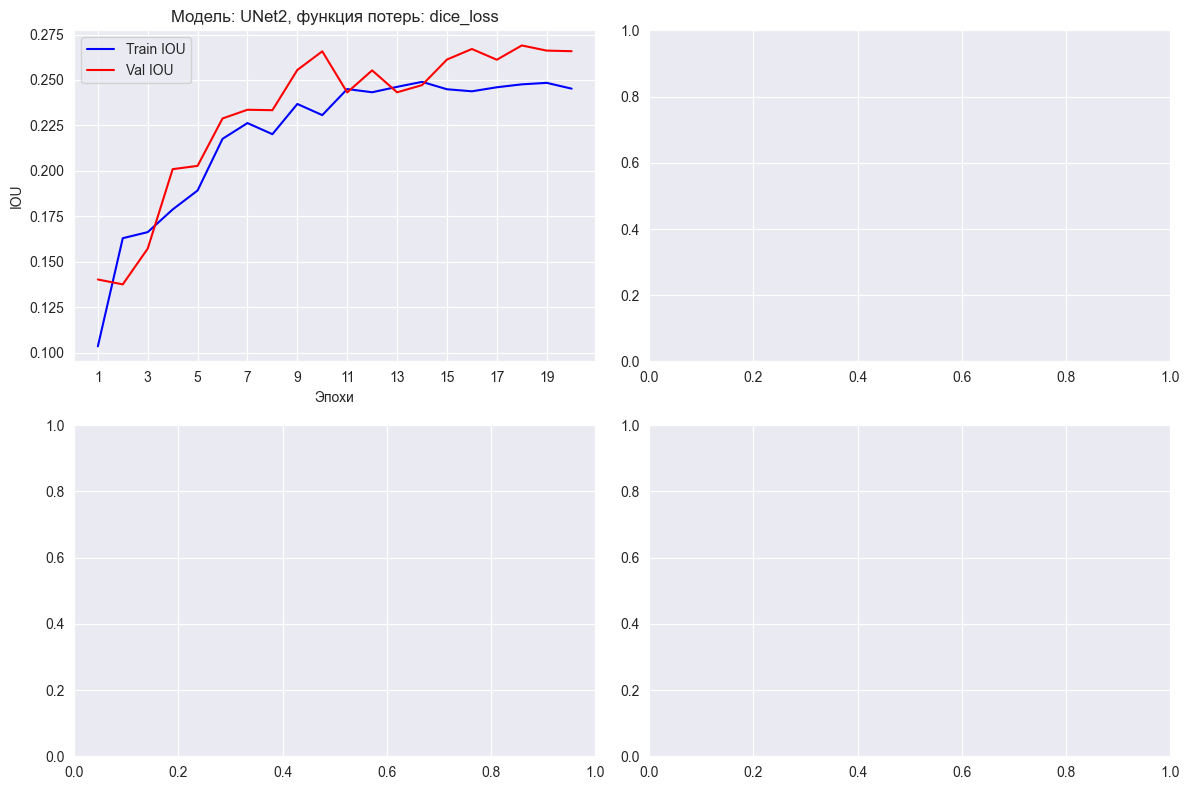

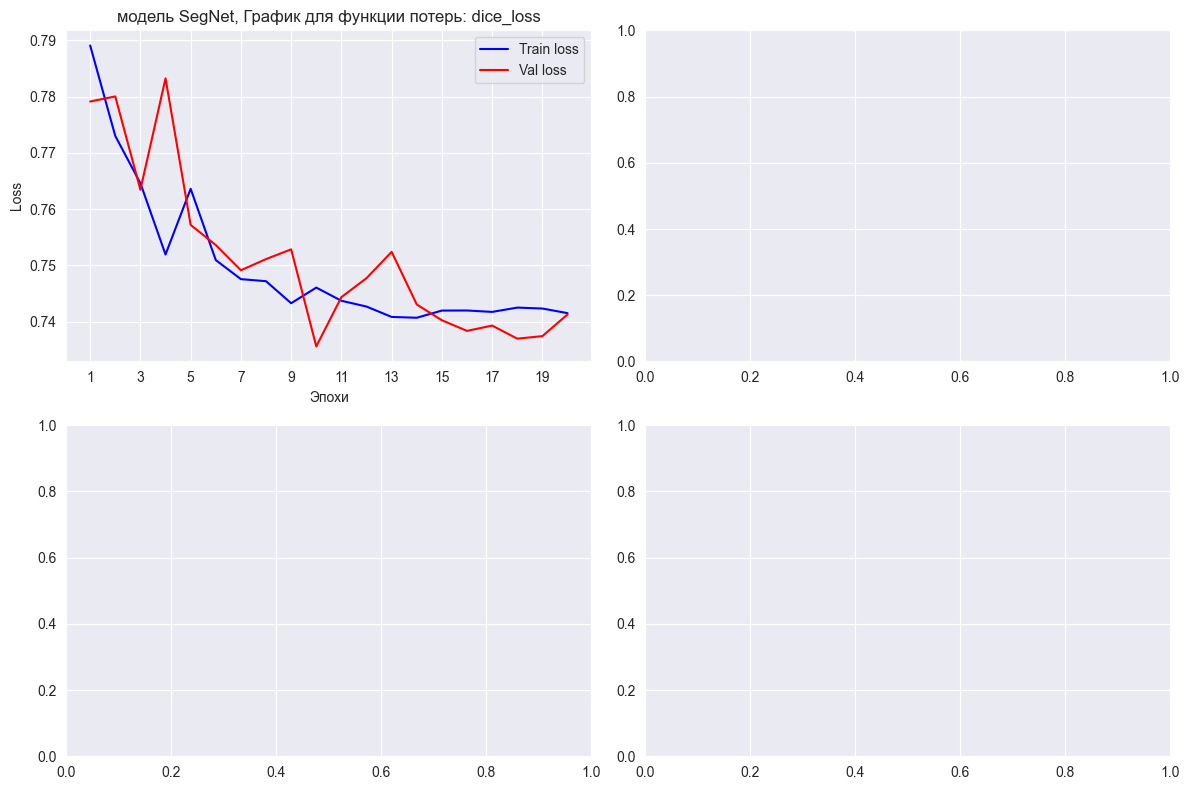

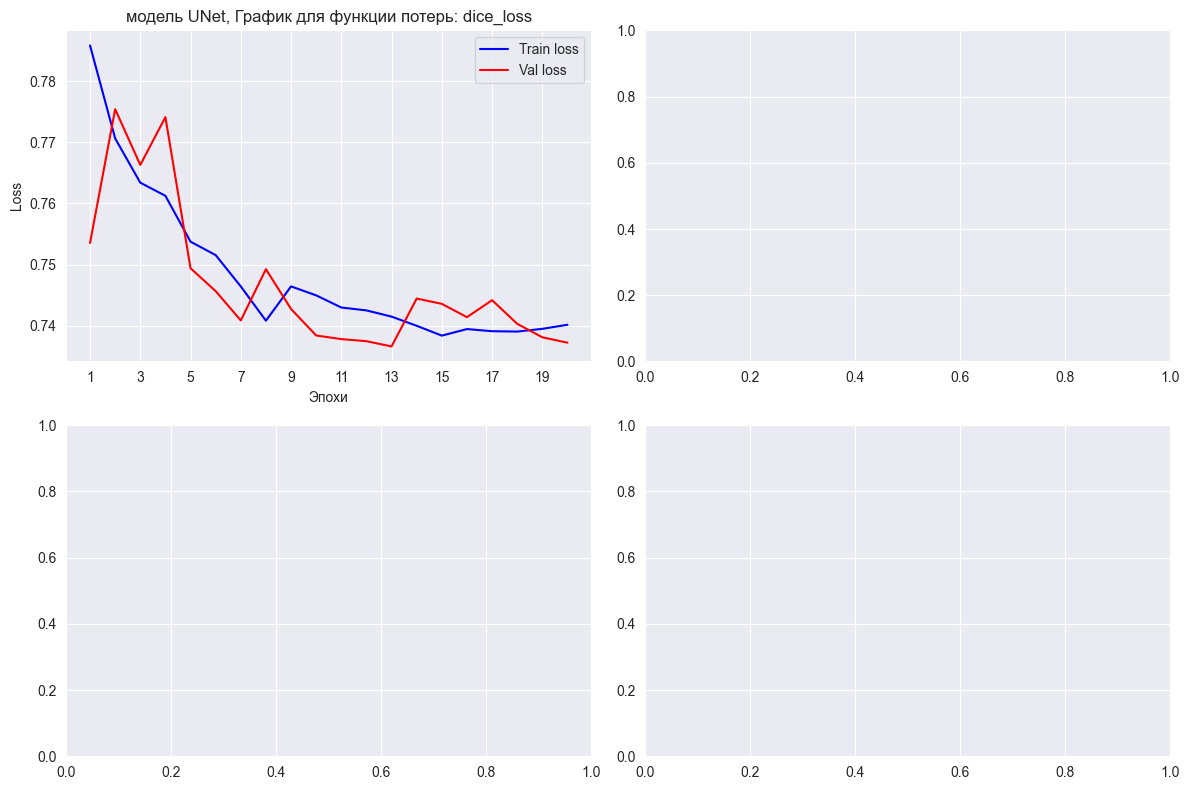

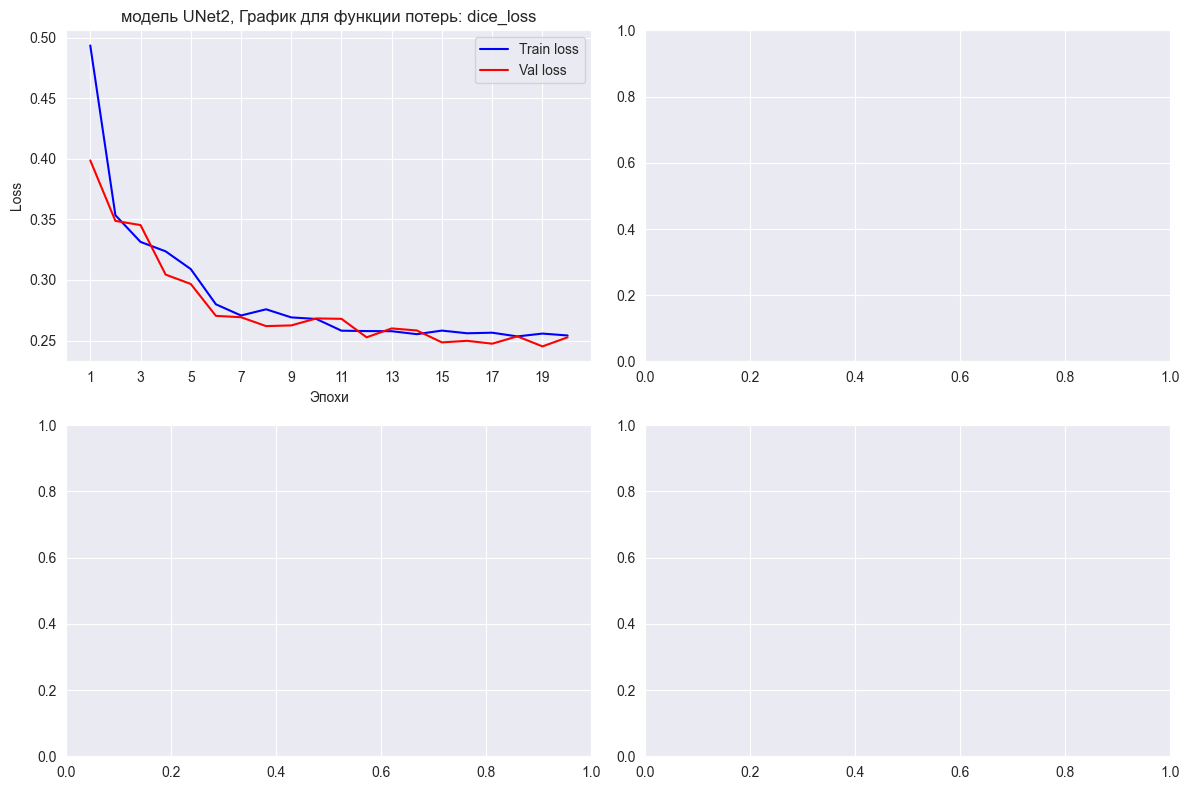

In [32]:
report = (pd.concat([make_report(history)])
            
)
# report

# Просмотр графиков процесса тренировки
display_chart_iou(report)  

display_chart_loss(report)  

In [33]:
report

,номер,модель,Функция потерь,Train loss,Val loss,Train IOU,Val IOU
0,1,SegNet,dice_loss,0.789112,0.779148,0.033725,0.010172839
1,1,SegNet,dice_loss,0.773015,0.780047,0.042958327,0.04592
2,1,SegNet,dice_loss,0.764611,0.763445,0.041958325,0.052479997
3,1,SegNet,dice_loss,0.751931,0.783263,0.056041658,0.0392
4,1,SegNet,dice_loss,0.763619,0.757199,0.047020823,0.071265295
5,1,SegNet,dice_loss,0.750941,0.753609,0.07151251,0.08493827
6,1,SegNet,dice_loss,0.747551,0.749126,0.07160419,0.096489795
7,1,SegNet,dice_loss,0.747187,0.751116,0.081208296,0.07159184
8,1,SegNet,dice_loss,0.743267,0.752848,0.08164585,0.09877549
9,1,SegNet,dice_loss,0.746048,0.735587,0.08244442,0.09550685


In [34]:
# Сводная таблица лучших результатов каждой модели по Val_loss
highlight_table(report)

,,номер,модель,Функция потерь,Train loss,Val loss,Train IOU,Val IOU
модель,Функция потерь,,,,,,,
UNet2,dice_loss,1,UNet2,dice_loss,0.253419,0.253480,0.24760275,0.2689876
SegNet,dice_loss,1,SegNet,dice_loss,0.742323,0.737415,0.09768381,0.117432125
UNet,dice_loss,1,UNet,dice_loss,0.742492,0.737456,0.07863887,0.10000001


In [35]:
# таблица времени обучения моделей
time_table(train_time)

,Model,Loss Function,время,time
2,UNet2,dice_loss,0:47:36:791 мс,2856.791944
0,SegNet,dice_loss,1:16:8:136 мс,4568.136151
1,UNet,dice_loss,2:26:22:893 мс,8782.893180


In [36]:
with torch.no_grad():
    torch.cuda.empty_cache()  #очистить ресурсы  GPU

## Проверка моделей на тестовом наборе

Модель успешно загружена и готова к использованию.


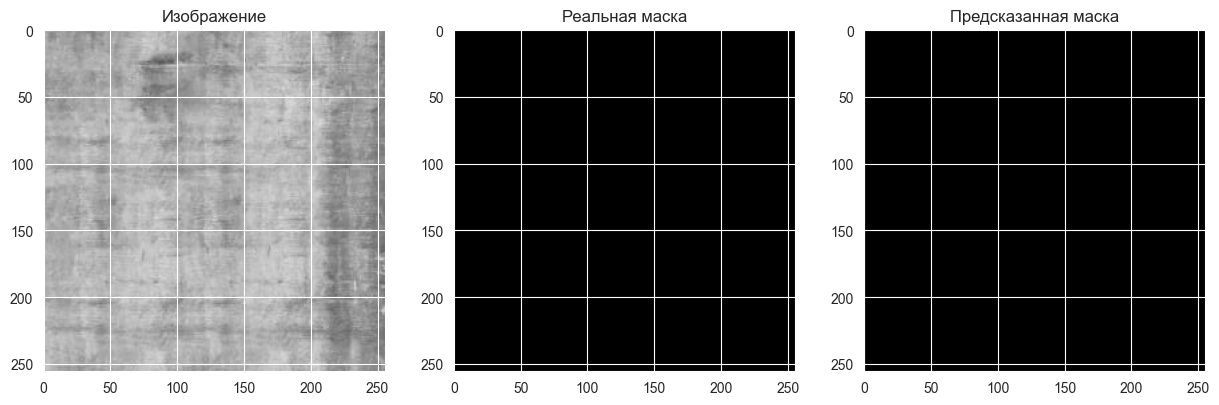

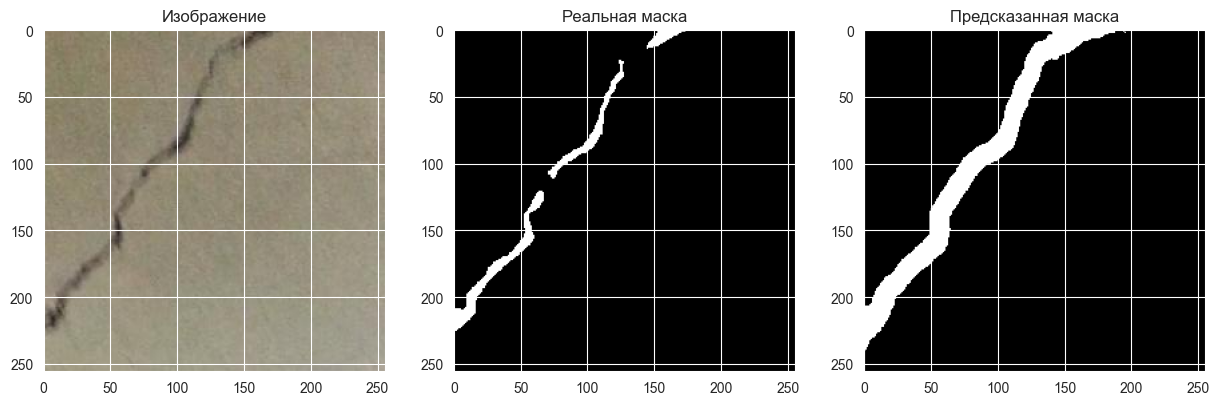

In [43]:
model = load_models(model_SegNet1, name_Net="SegNet")
predict(model, data_ts, F.sigmoid, 2)

Модель успешно загружена и готова к использованию.


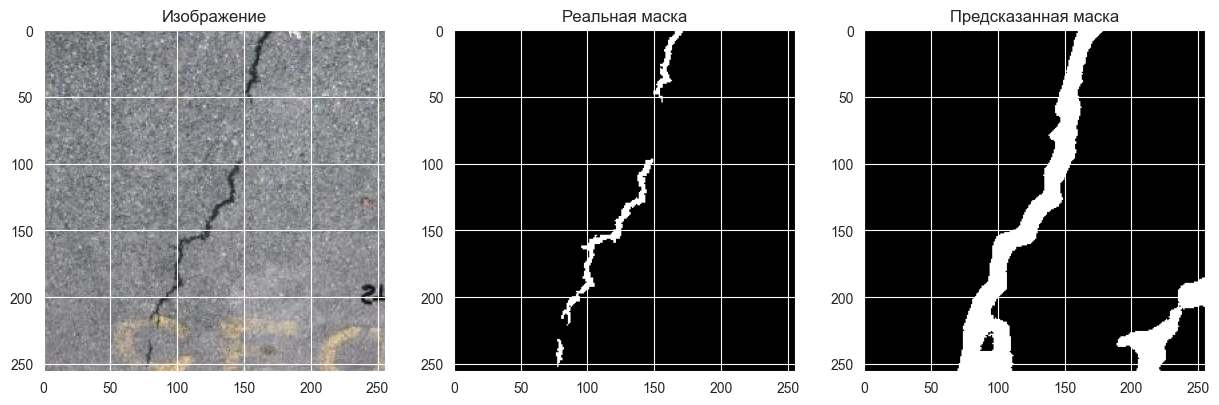

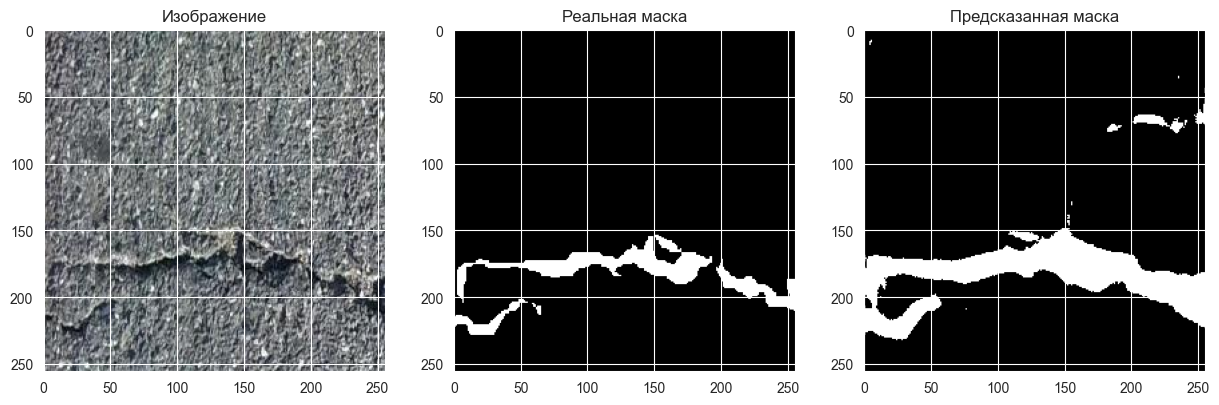

In [44]:
model = load_models(model_Unet1, name_Net="UNet")
predict(model, data_ts, F.sigmoid, 2)

Модель успешно загружена и готова к использованию.


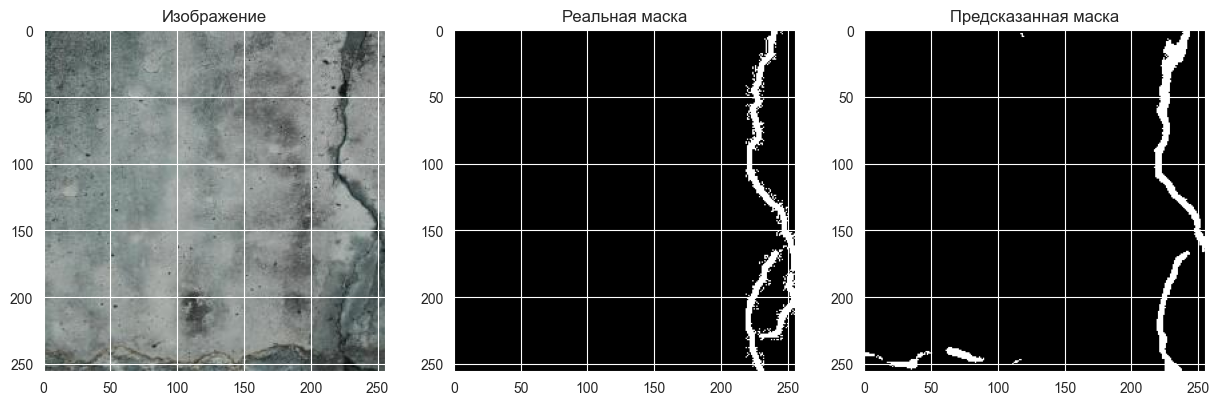

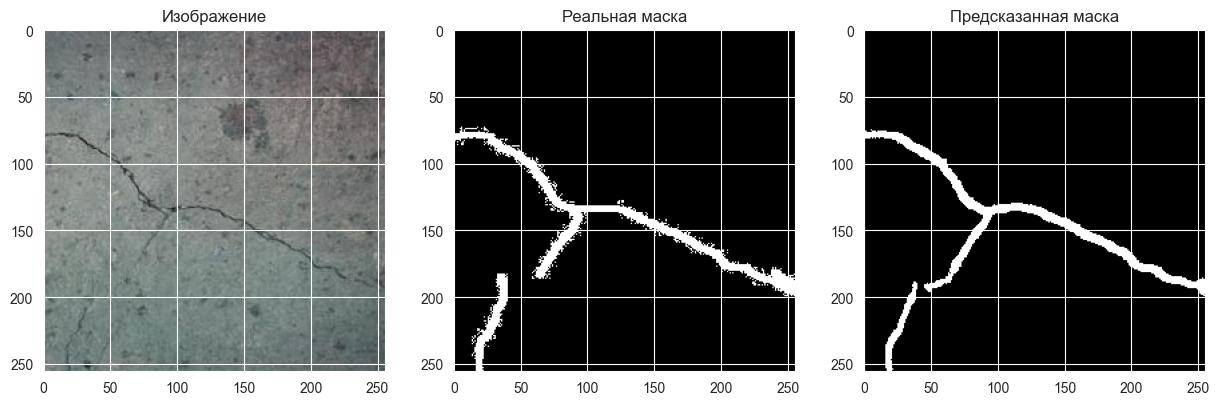

In [47]:
model = load_models(model_Unet2, name_Net="UNet2")
predict(model, data_ts, F.sigmoid, 2)

In [48]:
score = score_model(model, iou_pytorch, data_ts)


In [49]:
score

0.2504545392637903

In [50]:
with torch.no_grad():
    torch.cuda.empty_cache()  #очистить ресурсы  GPU